# CNN - yet another model

Consider senate number 115, this notebook aims to predict votes profile for a bill using the following information:
1. Political party
2. Cosponsors

In [28]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline 

from lib import models, graph, coarsening, utils

In [29]:
VOTES_115 = '../data/all-votes/votes_115.csv'
BILLS_115 = '../data/bills_115.csv'
ADJACENCY = '../data/adjacency_normalized.csv'

In [30]:
all_bills = pd.read_csv(BILLS_115)
votes_115 = pd.read_csv(VOTES_115)
bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators
N_BILLS_SEN = bills_sen.shape[0]

In [31]:
members_aux = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
members = members_aux.merge(votes_115.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
N_SENATORS = len(members)

In [32]:
for i,j in enumerate(bills_sen.cosponsors_sen):
    bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)

In [33]:
bills_sen.head()

,Unnamed: 0,bill_api_uri,date,democrats_no,democrats_yes,independent_no,independent_yes,month,republican_no,republican_yes,...,sponsor_id,sponsor_party,sponsor_title,result_ok,nb_cosponsors_R,nb_cosponsors_D,nb_cosponsors_I,cosponsors_sen,cosponsors_rep,cosponsors_del
1,1,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,16,30,1,1,1,0,50,...,M000303,R,Sen.,passed,0,0,0,[],[],[]
2,3,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
3,4,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
4,5,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
5,6,https://api.propublica.org/congress/v1/115/bil...,2017-01-11,44,1,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]


Create binary matrices indicating sponsorship (and cosponsorship):

In [34]:
S = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1

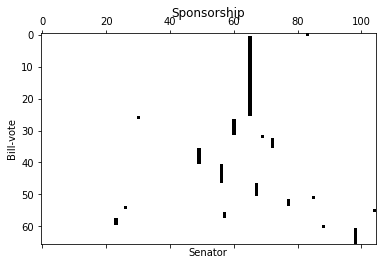

In [35]:
plt.spy(S)
plt.title('Sponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [36]:
CS = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
        CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1

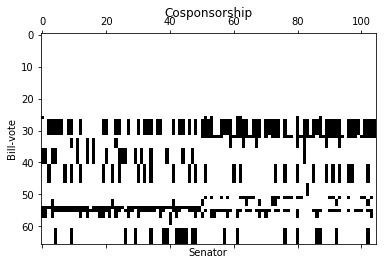

In [37]:
plt.spy(CS)
plt.title('Cosponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [38]:
Z = S + CS # sponsorship mask

In [39]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 2 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return 0

Get all votes for each bill-vote:

In [40]:
Y=np.zeros((N_BILLS_SEN, N_SENATORS))

for i, l in enumerate(list(bills_sen.vote_uri)):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    Y[i] = feature

Use as feature number 1 only the votes for sponsors:

In [41]:
X_aux = -np.ones((N_BILLS_SEN, N_SENATORS))
X_aux[Z==1]=Y[Z==1]

Use as feature number 2 only the parties:

In [42]:
Y1 = votes.party.values
Y1[Y1=='D']=0
Y1[Y1=='R']=1
Y1[Y1=='I']=2

Matrix $X$, used for training and validation, consists of 2 features:
1. Sponsors voting profile for 3 bill-votes
2. Political parties for each sponsor 

In [43]:
X = np.array([X_aux[39:42].flatten(), np.kron(np.ones(3), Y1)]).T
y = Y[39:42].flatten()
X.shape

(315, 2)

Matrix $X_{test}$, used for test, consists of the same features for another bill-vote:

In [44]:
X_test0 = np.array([X_aux[42:43].flatten(), np.kron(np.ones(1), Y1)]).T
y_test  = Y[42:43].flatten()

In [45]:
n = X.shape[0]
d = X.shape[1]

print('n = {}\nd = {}'.format(n, d))

n = 315
d = 2


In [46]:
n_train = int(.8 * n)

perm = np.random.permutation(n)
X_train0 = X[perm[:n_train]]
X_val0   = X[perm[n_train:]]

y_train = y[perm[:n_train]]
y_val   = y[perm[n_train:]]

d = |V| = 2, k|V| < |E| = 4492


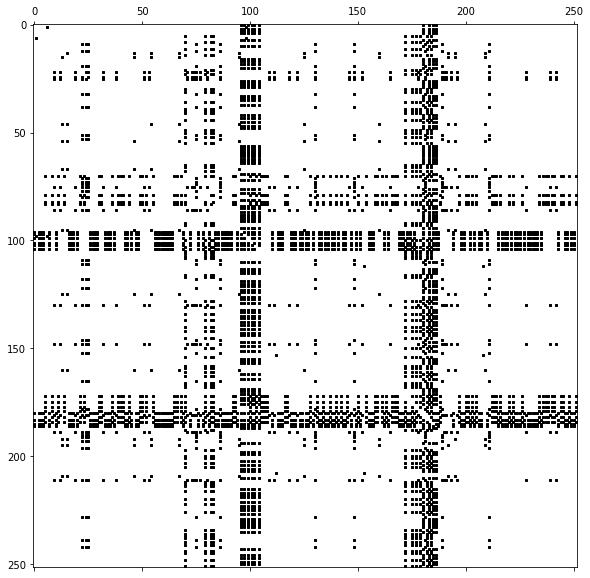

In [47]:
dist, idx = graph.distance_scipy_spatial(X_train0, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)
assert A.shape == (n_train, n_train)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

In [48]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(X_train0, perm)
X_val = coarsening.perm_data(X_val0, perm)
X_test = coarsening.perm_data(X_test0, perm)

Layer 0: M_0 = |V| = 1200 nodes (948 added),|E| = 2246 edges
Layer 1: M_1 = |V| = 600 nodes (385 added),|E| = 1902 edges
Layer 2: M_2 = |V| = 300 nodes (120 added),|E| = 1588 edges
Layer 3: M_3 = |V| = 150 nodes (0 added),|E| = 1307 edges


In [49]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

In [50]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 10 # changed
params['eval_frequency'] = 50 # changed

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1 # changed
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [51]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 1200
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1200 * 32 / 4 = 9600
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 300 * 64 / 2 = 9600
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 9600 * 512 = 4915200
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 3.0
    weights: M_3 * M_4 = 512 * 3.0 = 1536.0
    biases: M_4 = 3.0
step 50 / 1008 (epoch 1.98 / 40):
  learning_rate = 9.50e-04, loss_average = 1.06e+01


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 31.75 (20 / 63), f1 (weighted): 15.30, loss: 1.16e+01
  time: 23s (wall 5s)
step 100 / 1008 (epoch 3.97 / 40):
  learning_rate = 8.57e-04, loss_average = 1.04e+01
  validation accuracy: 31.75 (20 / 63), f1 (weighted): 15.30, loss: 1.16e+01
  time: 47s (wall 11s)
step 150 / 1008 (epoch 5.95 / 40):
  learning_rate = 7.74e-04, loss_average = 1.04e+01
  validation accuracy: 61.90 (39 / 63), f1 (weighted): 47.34, loss: 1.15e+01
  time: 70s (wall 16s)
step 200 / 1008 (epoch 7.94 / 40):
  learning_rate = 6.98e-04, loss_average = 1.03e+01
  validation accuracy: 61.90 (39 / 63), f1 (weighted): 47.34, loss: 1.15e+01
  time: 93s (wall 21s)
step 250 / 1008 (epoch 9.92 / 40):
  learning_rate = 6.30e-04, loss_average = 1.03e+01
  validation accuracy: 76.19 (48 / 63), f1 (weighted): 74.44, loss: 1.15e+01
  time: 116s (wall 26s)
step 300 / 1008 (epoch 11.90 / 40):
  learning_rate = 5.69e-04, loss_average = 1.04e+01
  validation accuracy: 53.97 (34 / 63), f1 (weighted): 51.11, lo

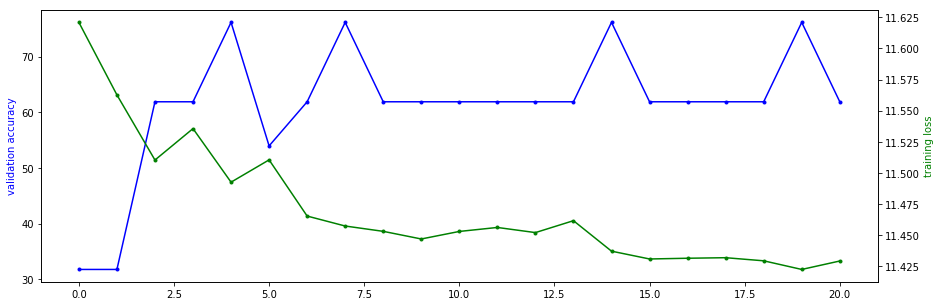

In [52]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [53]:
res = model.evaluate(X_test, y_test)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-1008
accuracy: 64.76 (68 / 105), f1 (weighted): 51.85, loss: 1.08e+01
time: 3s (wall 1s)


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
